# A Comparison of U.S. Flight Delays Over 3 Decades
## by Matt Brendel

## Investigation Overview

In this investigation, I find out which destination airports/cities have more delays & which carriers have the best on-time performance over the three decades. The main variables we explore are departure delay (in mins), elapsed flight time (in mins), year, and unique carrier (airline code).

## Dataset Overview

The dataset consists of flights in the United States, including carriers, arrival and departure delays, and reasons for delays in 1988, 1998, and 2008.
Source: http://stat-computing.org/dataexpo/2009/the-data.html

## Load & Tidy Data

In [134]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [135]:
# load in the dataset into a pandas dataframe
flt88 = pd.read_csv('1988.csv')
flt98 = pd.read_csv('1998.csv')
flt08 = pd.read_csv('2008.csv')

In [136]:
# concatenate datasets into one df 
flts = pd.concat([flt88, flt98, flt08], ignore_index=True)

In [137]:
# copy original df before cleaning
flts_c = flts.copy()

In [138]:
# drop columns with a majority of missing data, or cols we simply won't need for analysis
flts_c = flts_c.drop(['TailNum', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

In [139]:
# fill NAs with means for columns where it makes sense to do so (minutes, miles, etc)
fill_mean = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut'];
for col in fill_mean:
    flts_c[col].fillna(flts_c[col].mean(), inplace=True)

In [140]:
# drop rows with negative elapsed time (only 4 rows)
flts_c = flts_c[flts_c['CRSElapsedTime'] >= 0]

In [141]:
# constrain df to only rows where carriers are from top 5
flts_c = flts_c[flts_c['UniqueCarrier'].isin(['WN','DL','AA','UA','US'])]

## Distribution of Delay Times

As the dataset is quite large, delay times take on a very wide range of values, from -1000 (negative numbers meaning the flight left early) to almost 2500. Summary statistics reveal that most of the data falls between -5 and 10 min delay, though, so we will focus our visualization. Plotted on a logarithmic scale, the distriution of delays reveals that most flights are on time, with the highest bar concentrated between -1 and 0 mins.

In [142]:
# There is a long tail in the distribution, so let's put it on a log scale instead
# Since DepDelay has negative values, we need to account for them in a log_trans function by taking the absolute
# value of the delay and then reassigning the negative sign after taking the log
def log_trans(x, inverse = False):
    if not inverse:
        if x < 0:
            return np.log10(abs(x)) * -1
        elif x == 0:
            return x
        else:
            return np.log10(x)
    else:
        return np.power(10, x)
# new column in df for the log delays
flts_c['logDepDelay'] = flts_c['DepDelay'].apply(log_trans);

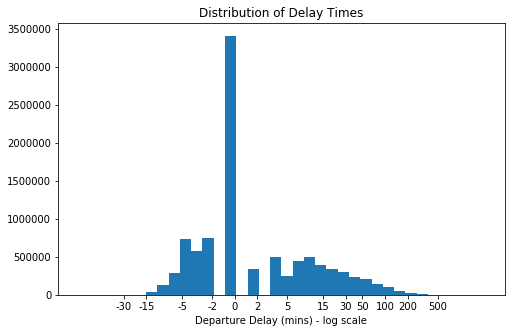

In [143]:
# plot histogram of log departure delays
plt.figure(figsize=[8, 5])
bin_edges = np.arange(flts_c['logDepDelay'].min(), flts_c['logDepDelay'].max()+0.15, 0.15);
plt.hist(data = flts_c, x = 'logDepDelay', bins = bin_edges);
tick_locs = [-30, -15, -5, -2, 0, 2, 5, 15, 30, 50, 100, 200, 500];
log_tick_locs = []
for c in tick_locs:
    log_tick_locs.append(log_trans(c))
plt.xticks(log_tick_locs, tick_locs)
plt.xlabel('Departure Delay (mins) - log scale');
plt.title('Distribution of Delay Times');

## Distribution of Flight Times

CRSElapsedTime represents the elapsed flight time, where CRS= Computerized Reservations System. As there are many flight times within 150 mins, and fewer and fewer up to about 1500 mins, we take a log transformation to visualize the data better. The plot looks fairly uniform, with slight peaks at ~85 and 250 mins, which align with typical regional flights just over 1.5 hours and popular cross-country flights over 4 hours.

In [144]:
# create column for log of elapsed time
flts_c['logCRSElapsedTime'] = flts_c['CRSElapsedTime'].apply(log_trans);

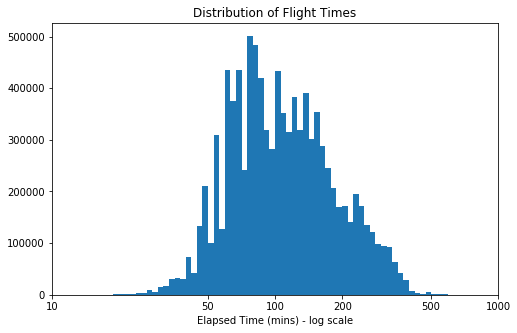

In [145]:
# histogram on log of CRSElapsedTime
plt.figure(figsize=[8, 5])
bin_edges = np.arange(flts_c['logCRSElapsedTime'].min(), flts_c['logCRSElapsedTime'].max()+0.025, 0.025);
plt.hist(data = flts_c, x = 'logCRSElapsedTime', bins = bin_edges);
tick_locs = [10, 50, 100, 200, 500, 1000];
log_tick_locs = []
for c in tick_locs:
    log_tick_locs.append(log_trans(c))
plt.xticks(log_tick_locs, tick_locs)
plt.xlim(np.log10(10),np.log10(1000))
plt.xlabel('Elapsed Time (mins) - log scale');
plt.title('Distribution of Flight Times');

## How Delays Stack Up for the Major Destinations and Airlines

As there are 200 unique destinations in the dataset, we focus on the top 15 by flight volume. We see that SFO has the highest mean delay, at just under 14 mins. Nine of the 15 destinations have between 8-10 minute delays. UA has the highest mean delay amongst the carriers, while DL has the lowest.

We include error bars to represent the uncertainty in the mean based on variance and sample size; their relatively small size highlights the robust data set.

In [146]:
# since there are too many destinations to digest at once, filter df to top 15 (found during exploratory analysis)
TopDests = ['ORD','DFW','ATL','LAX','DEN','SFO','PHX','LAS','PHL','PIT','CLT','SLC','MCO','LGA','BOS'];
flt_sampTopDest = flts_c[flts_c['Dest'].isin(TopDests)];

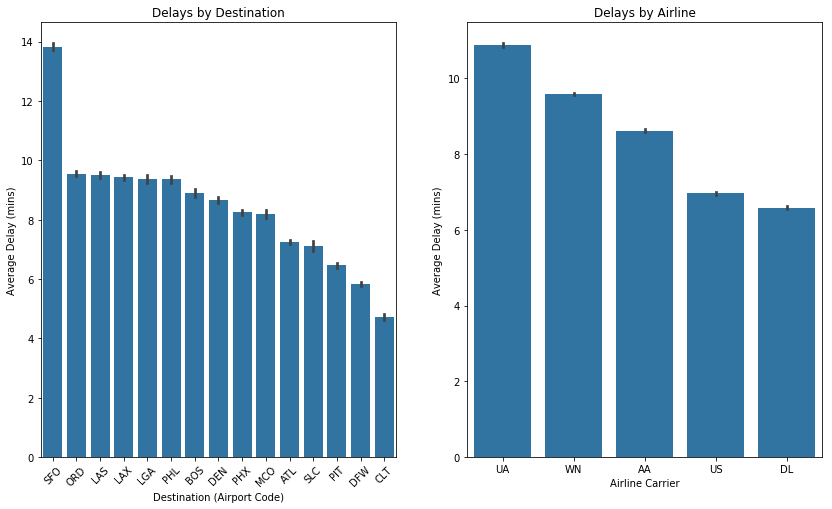

In [147]:
# declare ax and fig objects and vars of interest
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = [14,8])
base_color = sb.color_palette()[0]

plt.subplot(1, 2, 1)
# group data by mean for each Dest
group_means = flt_sampTopDest.groupby(['Dest']).mean()
# reorder by ascending DepDelay
group_order = group_means.sort_values(['DepDelay'], ascending = False).index
# plot mean Delay by Destination
ax = sb.barplot(data = flt_sampTopDest, x = 'Dest', y = 'DepDelay', color = base_color, order = group_order)
# rotate x-axis labels for readability
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.ylabel('Average Delay (mins)');
plt.xlabel('Destination (Airport Code)');
plt.title('Delays by Destination');

plt.subplot(1, 2, 2)
# group data by mean for each Dest. Use full dataset since we don't need to filter to the top 15 destinations.
group_means = flts_c.groupby(['UniqueCarrier']).mean()
# reorder by ascending DepDelay
group_order = group_means.sort_values(['DepDelay'], ascending = False).index
# plot mean Delay by Carrier
sb.barplot(data = flts_c, x = 'UniqueCarrier', y = 'DepDelay', color= base_color, order = group_order)
plt.ylabel('Average Delay (mins)');
plt.xlabel('Airline Carrier');
plt.title('Delays by Airline');
plt.show()

## Delays Across Three Decades

Continuing our analysis from before, we further segment delays to split by Year. We see that delays have risen over the three years plotted, on average, with 2008 showing the highest mean delay across the different destinations and carriers. The only destinations that seem to counter that trend heavily are PHX and CLT; it would be interesting to learn whether those airports have recently undergone renovations which better enable their traffic flow.

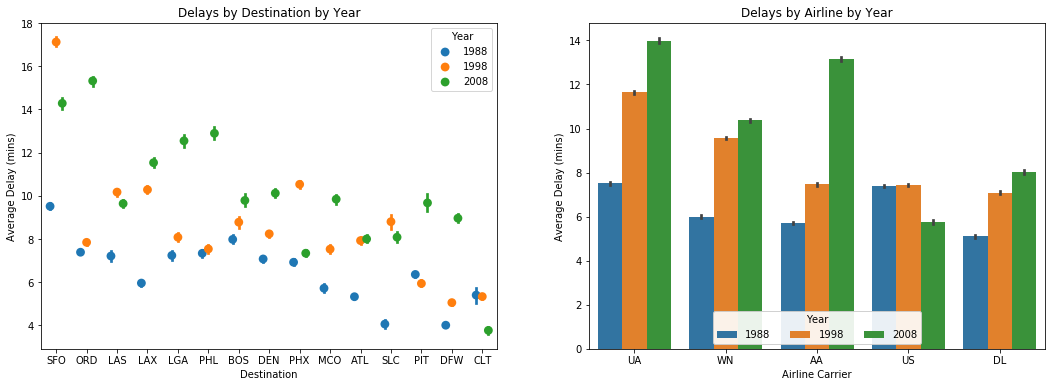

In [148]:
# declare ax and fig objects and vars of interest
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = [18,6])
base_color = sb.color_palette()[0]

plt.subplot(1, 2, 1)
# set order of x-axis categorical var to align with ascending avg DepDelay
group_means = flt_sampTopDest.groupby(['Dest']).mean()
group_order = group_means.sort_values(['DepDelay'], ascending = False).index
#fig = plt.figure(figsize = [15,6])
# plot pointplot with Year as the colored, third var
ax = sb.pointplot(data = flt_sampTopDest, x = 'Dest', y = 'DepDelay', hue = 'Year',
           linestyles = '', dodge = 0.4, order= group_order)
plt.ylabel('Average Delay (mins)');
plt.xlabel('Destination');
plt.title('Delays by Destination by Year');

plt.subplot(1, 2, 2)
# group data by mean for each Dest
group_means = flts_c.groupby(['UniqueCarrier']).mean()
# reorder by the relevant var mean
group_order = group_means.sort_values(['DepDelay'], ascending = False).index
# plot mean Delay by Destination
sb.barplot(data = flts_c, x = 'UniqueCarrier', y = 'DepDelay', hue = 'Year', order = group_order)
plt.ylabel('Average Delay (mins)');
plt.xlabel('Airline Carrier');
plt.legend(loc=8, ncol=3, framealpha= 0.9, title= 'Year');
plt.title('Delays by Airline by Year');
plt.show()

## Heat Map of Delays Versus Flight Times

Lastly, it is interesting to observe a heat map of delay times versus elapsed flight times faceted by carrier. On both axes, I purposefully zoom in on where the majority of data exists so that a clear visualization results. The lightest yellow square appears only if at least 1000 flights match the axes criteria.

The plot gives us greater insight into the different carriers' flight patterns. Our finding that UA and AA serve the longest flights is backed up by the wide range of darker color across the elapsed time axis; the majority of UA's flights fall between 60 and 156 mins, whereas WN, a smaller, more regional airline, has a thinner band between 60 and 72 mins.

The coloring also helps us interpret the delays per carrier. We can see UA's delays fall distinctly between -3 to 9 mins whereas for WN, the color, albeit lighter, extends higher, indicating more variability or spread to that airline's delays.

In [149]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    # zoom in on top 75% of data for more granular color coding
    bins_x = np.arange(0,165+12,12);
    bins_y = np.arange(-5,18+2,2);
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 6000);
    plt.xticks(bins_x);
    plt.yticks(bins_y);

Heat Map of Delays Versus Flight Times


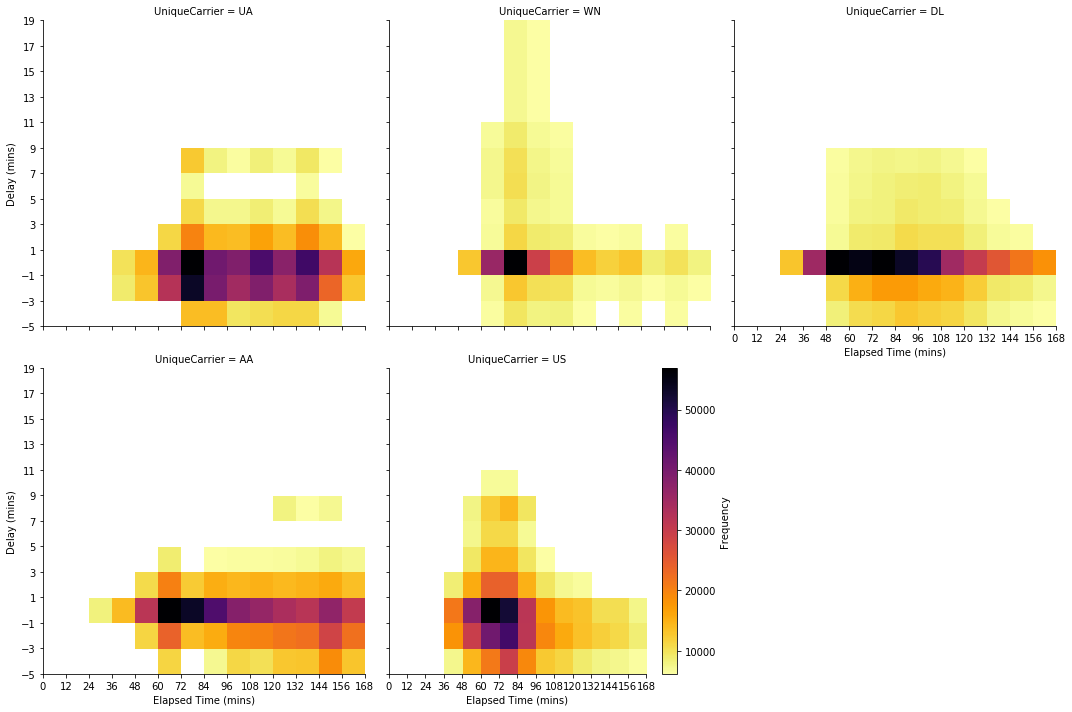

In [150]:
# create faceted heat maps on levels of the Carrier variable
g = sb.FacetGrid(data = flts_c, col = 'UniqueCarrier', col_wrap = 3, height = 5)
g.map(hist2dgrid, 'CRSElapsedTime', 'DepDelay', color = 'inferno_r')
g.set_xlabels('Elapsed Time (mins)');
g.set_ylabels('Delay (mins)');
plt.colorbar().set_label('Frequency');
print('Heat Map of Delays Versus Flight Times');
plt.show()